In [2811]:
import pandas as pd, numpy as np
from scipy import stats

In [2812]:
stations=pd.read_csv('data/stations.csv').set_index('ID')

In [2813]:
c='hu'
df=pd.read_csv('data/'+c+'_ds.csv') #daily data
# df=pd.read_csv('data/'+c+'_hs.csv') #high_res data
df['time']=pd.to_datetime(df['time'])
df['year']=df['time'].dt.year
df['month']=df['time'].dt.month
df['day']=df['time'].dt.day
df['hour']=df['time'].dt.hour
df=df.set_index('time')
df=df.sort_index()

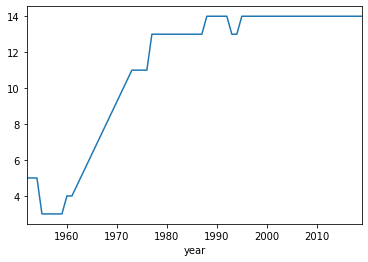

In [2814]:
df.groupby('year').nunique()['ID'].plot()

In [2815]:
history=df.groupby('ID').nunique()['year'].sort_values(ascending=False)
history=pd.DataFrame(history).join(stations)
history.head()

,year,Unnamed: 0,LOC,COUNTRY,LAT,LON,ELEVATION
ID,,,,,,,
128820,55,28,DEBRECEN,HUNGARY,47.489,21.615,110.0
128120,55,5,SZOMBATHELY ARPT / VAS,HUNGARY,47.283,16.633,223.1
127720,55,2,MISKOLC,HUNGARY,48.083,20.767,236.0
128600,52,22,SZOLNOK,HUNGARY,47.123,20.236,98.1
128390,50,14,FERIHEGY,HUNGARY,47.437,19.256,150.9


In [2818]:
nepi=pd.read_excel(c+'/idojaras_'+c+'.xlsx')

Setup plot params

In [2820]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import PolyCollection
%matplotlib inline

In [2821]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager
path = 'KulimPark-Regular.ttf'
path2 = 'Symbola.ttf'
prop = font_manager.FontProperties(fname=path)
prop2 = font_manager.FontProperties(fname=path2)

In [2822]:
color_ax='#E7CFBC'
color_bg='#FFF4EC'
color_obs_right0='#F2B880'
color_obs_left0=color_ax
color_pred_right0='#C98686'
color_pred_left0='#966B9D'
color_pred_talalt0='#59c687'
color_pred_nem_talalt0='#c95498'
font_size=12
s=40
obs_talalt_glyph0='★'
obs_nem_talalt_glyph0='☆'
pred_talalt_glyph0='✔️'
pred_nem_talalt_glyph0='✖️'
title_icon_right={'Temp':'☼','Wind':'►','Hail':'▲','Snow':'▲','Snow Depth':'▲','Rain':'☔️','Visib':'☀️'}
title_icon_left={'Temp':'❄️','Wind':'◄','Hail':'▼','Snow':'▼','Snow Depth':'▼','Rain':'☂️','Visib':'☁️'}
title_icon={'Temp':'♨️','Rain':'☂️','Hail':'❄️','Snow':'⛷️','Snow Depth':'⛄️','Wind':'☘','Cloud':'☁️','Visib':'☀️'}

In [2823]:
def get_data(data,th):
    a1=pd.DataFrame(data[data<=th])
    a1['g']='left'
    a2=pd.DataFrame(data[data>th])
    a2['g']='right'
    a3=pd.concat([a1,a2])
    a3['x']='x'
    return a1,a2,a3

In [2824]:
def violin_plot(data,th,ax,color_left,color_right):
    a=0.3
    a1,a2,a3=get_data(data,th)
    if len(a1)==1: 
        a11=pd.DataFrame(a1)
        a11['x']='x'
        a11[a1.columns[0]]=[a1[a1.columns[0]].values[0]*1.1]
        a3=pd.concat([a3,a11])
    ax.axvline(0,color=color_ax)
    if a3.nunique()['g']>1:
        sns.violinplot(y=a1.columns[0], x='x',hue='g', data=a3, split=True, ax=ax,
                      inner=None,linewidth=1, scale="count", saturation=1)

        ax.get_children()[0].set_color(matplotlib.colors.colorConverter.to_rgba(color_left, alpha=a))
        ax.get_children()[0].set_edgecolor(color_left)
        ax.get_children()[1].set_color(matplotlib.colors.colorConverter.to_rgba(color_right, alpha=a))
        ax.get_children()[1].set_edgecolor(color_right)
        ax.legend().remove()
    else:
        if len(a1)>0: 
            w=a1
            c=color_left
        else: 
            w=a2
            c=color_right
        sns.violinplot(y=w.columns[0], data=w, ax=ax, 
                       inner=None,linewidth=1, scale="count", saturation=1)
        ax.set_xlim([-1,0])
        ax.get_children()[0].set_color(matplotlib.colors.colorConverter.to_rgba(c, alpha=a))
        ax.get_children()[0].set_edgecolor(c)

In [2825]:
def setup_axes():
    fig,axes=plt.subplots(1,3,figsize=(8,5),gridspec_kw={'width_ratios': [1, 3, 1]})
    axi_top= axes[2].inset_axes([0.1, 0.65, 1, 0.3])
    axi_top.axis('off')
    axi_bottom= axes[2].inset_axes([0.1, 0, 1, 0.5])
    axi_bottom.axis('off')
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    axes[0]=axes[0].inset_axes([0, 0.15, 1, 0.85])
    axes[1]=axes[1].inset_axes([0, 0.15, 1, 0.85])
    axes[0].axis('off')
    axes[1].axis('off')
    return fig, axes, axi_top, axi_bottom

In [2826]:
def stem_plot(data,ax,color,s=s):
    data=pd.DataFrame(data)
    x=data.index
    y=data[data.columns[0]].values
    for i,e in enumerate(y):
        ax.plot([0,e],[x[i],x[i]],color=color)
    ax.scatter(y,x,s,color=color,zorder=10)

In [2827]:
def stem2_plot(data,th,ax,color_left,color_right,s=s,axv_color=None):
    if axv_color==None:axv_color=color_right
    a1,a2,a3=get_data(data,th)
    stem_plot(a1,ax,color_left,s)
    stem_plot(a2,ax,color_right,s)
    ax.axvline(0,color=color_ax)
    #if th!=0:
    if True:
        ax.axvline(th,color=axv_color,ls='--',zorder=5)

In [2828]:
def icons_plot(axes,kondicio,mennyiseg,observation_th,prediction_th):
    ylim=axes[0].get_ylim()
    xlim=axes[1].get_xlim()
    y_max_coord=ylim[0]+(ylim[1]-ylim[0])*1.05
    y_max_coord2=ylim[0]+(ylim[1]-ylim[0])*1.05 #1.04
    x_icon_coord_shift=(xlim[1]-xlim[0])*0.1
    axes[0].text(observation_th, y_max_coord, title_icon[kondicio], 
            horizontalalignment='center', color=color_obs_right0, fontproperties=prop2, fontsize=font_size*1.5)
    axes[1].text(prediction_th, y_max_coord, title_icon[mennyiseg], 
            horizontalalignment='center', color=color_ax, fontproperties=prop2, fontsize=font_size*1.5)
    axes[1].text(prediction_th+x_icon_coord_shift, y_max_coord2, title_icon_right[mennyiseg], 
            horizontalalignment='center', color=color_pred_right, fontproperties=prop2, fontsize=font_size*1.5)
    axes[1].text(prediction_th-x_icon_coord_shift, y_max_coord2, title_icon_left[mennyiseg], 
            horizontalalignment='center', color=color_pred_left, fontproperties=prop2, fontsize=font_size*1.5)

In [2829]:
def talalat_plot_line(axes,n_prediction_ts_good,n_prediction_ts_bad,
                        n_prediction_ts_good_talalt,n_prediction_ts_good_nem_talalt,
                      observation_th,prediction_th):
    ylim=axes[0].get_ylim()
    xlim=axes[0].get_xlim()
    y_max_coord=ylim[0]+(ylim[1]-ylim[0])*(-0.07)
    x_icon_coord_shift=(xlim[1]-xlim[0])*0.1
    x_icon_coord_shift2=(xlim[1]-xlim[0])*0.27
    axes[0].text(observation_th+x_icon_coord_shift, y_max_coord, obs_talalt_glyph, 
            horizontalalignment='center', color=color_obs_right, fontproperties=prop2)
    axes[0].text(observation_th-x_icon_coord_shift, y_max_coord, obs_nem_talalt_glyph, 
            horizontalalignment='center', color=color_obs_left, fontproperties=prop2)
    axes[0].text(observation_th+x_icon_coord_shift2, y_max_coord, n_prediction_ts_good, 
            horizontalalignment='center', color=color_obs_right, fontproperties=prop)
    axes[0].text(observation_th-x_icon_coord_shift2, y_max_coord, n_prediction_ts_bad, 
            horizontalalignment='center', color=color_obs_left, fontproperties=prop)
    axes[0].text(observation_th, y_max_coord, '|', 
            horizontalalignment='center', color=color_obs_right0, fontproperties=prop,fontsize=19)

    xlim=axes[1].get_xlim()
    x_icon_coord_shift=(xlim[1]-xlim[0])*0.04
    x_icon_coord_shift2=(xlim[1]-xlim[0])*0.1
    axes[1].text(prediction_th+x_icon_coord_shift, y_max_coord, pred_talalt_glyph, 
            horizontalalignment='center', color=color_pred_talalt, fontproperties=prop2)
    axes[1].text(prediction_th-x_icon_coord_shift, y_max_coord, pred_nem_talalt_glyph, 
            horizontalalignment='center', color=color_pred_nem_talalt, fontproperties=prop2)
    axes[1].text(prediction_th+x_icon_coord_shift2, y_max_coord, n_prediction_ts_good_talalt, 
            horizontalalignment='center', color=color_pred_talalt, fontproperties=prop)
    axes[1].text(prediction_th-x_icon_coord_shift2, y_max_coord, n_prediction_ts_good_nem_talalt, 
            horizontalalignment='center', color=color_pred_nem_talalt, fontproperties=prop)
    axes[1].text(prediction_th, y_max_coord, '|', 
            horizontalalignment='center', color=color_pred_right, fontproperties=prop,fontsize=19)
    
    y_max_coord=ylim[0]+(ylim[1]-ylim[0])*(-0.14)
    axes[0].text(observation_th, y_max_coord, 'feltétel', 
            horizontalalignment='center', color=color_obs_right0, fontproperties=prop)
    axes[1].text(prediction_th, y_max_coord, 'jóslat', 
            horizontalalignment='center', color=color_pred_right, fontproperties=prop)
    y_max_coord=ylim[0]+(ylim[1]-ylim[0])*(-0.13)
    x_coord_shift=prediction_th+(prediction_th-xlim[0])*(-0.4)
    axes[1].annotate('', xy=(x_coord_shift, y_max_coord),xycoords='data',annotation_clip=False,
             xytext=(xlim[0], y_max_coord),arrowprops=dict(arrowstyle= '->',color=color_obs_right0))

In [2830]:
def talalat_plot_violin(axes,n_prediction_ts_good,n_prediction_ts_bad,n_prediction_ts_good_talalt,n_prediction_ts_good_nem_talalt):
    y_icon_obs=0.65
    y_icon_pred=0.5
    if color_obs_right==color_obs_right0: x=0.72
    else: x=0.47
    axes[2].text(0.72, y_icon_obs, obs_talalt_glyph, 
            horizontalalignment='center', color=color_obs_right, fontproperties=prop2)
    axes[2].text(0.9, y_icon_obs,n_prediction_ts_good, 
            horizontalalignment='center', color=color_obs_right, fontproperties=prop)
    axes[2].text(0.47, y_icon_obs, obs_nem_talalt_glyph, 
            horizontalalignment='center', color=color_obs_left, fontproperties=prop2)
    axes[2].text(0.29, y_icon_obs, n_prediction_ts_bad, 
            horizontalalignment='center', color=color_obs_left, fontproperties=prop)
    
    axes[2].text(0.72, y_icon_pred, pred_talalt_glyph,
            horizontalalignment='center', color=color_pred_talalt, fontproperties=prop2)
    axes[2].text(0.9, y_icon_pred, n_prediction_ts_good_talalt, 
            horizontalalignment='center', color=color_pred_talalt, fontproperties=prop)
    axes[2].text(0.47, y_icon_pred, pred_nem_talalt_glyph, 
            horizontalalignment='center', color=color_pred_nem_talalt, fontproperties=prop2)
    axes[2].text(0.29, y_icon_pred, n_prediction_ts_good_nem_talalt,
            horizontalalignment='center', color=color_pred_nem_talalt, fontproperties=prop)
    
    axes[2].annotate('', xy=(0.59, y_icon_pred*1.04),xycoords='data',
             xytext=(x, y_icon_obs*0.98),arrowprops=dict(arrowstyle= '->',color=color_obs_right0))

In [2831]:
def talalat_plot(axes,ns,observation_th,prediction_th):
    n_prediction_ts_good,n_prediction_ts_bad,n_prediction_ts_good_talalt,n_prediction_ts_good_nem_talalt=ns
    talalat_plot_line(axes,n_prediction_ts_good,n_prediction_ts_bad,
                        n_prediction_ts_good_talalt,n_prediction_ts_good_nem_talalt,
                      observation_th,prediction_th)
    talalat_plot_violin(axes,n_prediction_ts_good,n_prediction_ts_bad,
                        n_prediction_ts_good_talalt,n_prediction_ts_good_nem_talalt)

In [2832]:
def year_plot(data,ax,k):
    y=data.values
    x=data.index
    ex=max(y)-min(y)
    text_off=abs(ex*k)
    text_align='left'
    if y[0]<0:
        text_off=-text_off
        text_align='right'
    ax.text(y[0]+text_off, x[0], str(x[0]), 
            horizontalalignment=text_align, verticalalignment='center', 
            color=color_ax, fontproperties=prop)
    text_off=abs(text_off)
    text_align='left'
    if y[-1]<0:
        text_off=-text_off
        text_align='right'
    ax.text(y[-1]+text_off, x[-1], str(x[-1]), 
            horizontalalignment=text_align, verticalalignment='center', 
            color=color_ax, fontproperties=prop)

In [2833]:
def spine_plot(datum,title,mondas,jelentes,kondicio,mennyiseg,
               observation_ts,observation_th,prediction_ts,prediction_th):
    
    #data
    prediction_ts_good=prediction_ts.loc[observation_ts[observation_ts>observation_th].index]
    prediction_ts_bad=prediction_ts.loc[observation_ts[observation_ts<=observation_th].index]
    n_prediction_ts_good=len(prediction_ts_good)
    n_prediction_ts_bad=len(prediction_ts_bad)
    
    if color_obs_right0!=color_obs_right:
        prediction_ts_good,prediction_ts_bad=prediction_ts_bad,prediction_ts_good
    prediction_ts_good_nem_talalt,prediction_ts_good_talalt,\
        prediction_ts_good_joined=get_data(prediction_ts_good,prediction_th)
    n_prediction_ts_good_talalt=len(prediction_ts_good_talalt)
    n_prediction_ts_good_nem_talalt=len(prediction_ts_good_nem_talalt)
    ns=[n_prediction_ts_good,n_prediction_ts_bad,n_prediction_ts_good_talalt,n_prediction_ts_good_nem_talalt]
    
    #plots
    fig, axes, axi_top, axi_bottom=setup_axes()
    
    stem2_plot(observation_ts,observation_th,axes[0],color_obs_left,color_obs_right,s/2,color_obs_right0)
    stem2_plot(prediction_ts_good,prediction_th,axes[1],color_pred_left,color_pred_right)
    stem_plot(prediction_ts_bad,axes[1],color_ax)
    
    violin_plot(observation_ts,observation_th,axi_top,color_obs_left,color_obs_right)
    violin_plot(prediction_ts_good,prediction_th,axi_bottom,color_pred_left,color_pred_right)
    
    #icons
    icons_plot(axes,kondicio,mennyiseg,observation_th,prediction_th)
    
    #talalat
    talalat_plot(axes,ns,observation_th,prediction_th)
    
    #years
    year_plot(observation_ts,axes[0],0.09)
    year_plot(prediction_ts,axes[1],0.03)
    
    #titles
    len_ratio=0.15*(-1+(len(jelentes.split(',')[0])/len(jelentes.split(',')[1])))
    fig.text(0.5+len_ratio,0.04,jelentes.split(',')[0]+',',color=color_obs_right0,
             fontproperties=prop,fontsize=font_size*0.7,horizontalalignment='right')
    if color_pred_talalt==color_pred_talalt0: color_pred_side=color_pred_right
    else: color_pred_side=color_pred_left
    fig.text(0.5+len_ratio,0.04,jelentes.split(',')[1],color=color_pred_side,
             fontproperties=prop,fontsize=font_size*0.7,horizontalalignment='left')
    if n_prediction_ts_good_nem_talalt>=n_prediction_ts_good_talalt:
        color_title=color_pred_nem_talalt
        verdict=pred_nem_talalt_glyph
    else: 
        color_title=color_pred_talalt
        verdict=pred_talalt_glyph
    plt.suptitle(title,y=0.11,color=color_title,fontproperties=prop,fontsize=font_size)
    fig.text(0.96,0.04,verdict, fontproperties=prop2,
            horizontalalignment='right', color=color_title, fontsize=font_size*2, )
    fig.text(0.04,0.045, datum, fontproperties=prop,
            horizontalalignment='left', color=color_obs_right0, fontsize=font_size*2, )
    
    plt.savefig(c+'/'+str(mondas)+'.png',dpi=300, facecolor=color_bg)
    plt.show()

In [2834]:
def filter_data(dz,observation_range,prediction_range):
    dgs=[]
    dhs=[]
    for year in range(int(dz.min()['year']),int(dz.max()['year'])):
        k=0
        from_date=pd.to_datetime(str(year)+'-'+str(observation_range[k].month)+'-'+str(observation_range[k].day))
        from_pred=pd.to_datetime(str(year)+'-'+str(prediction_range[k].month)+'-'+str(prediction_range[k].day))
        k=1
        to_date=pd.to_datetime(str(year)+'-'+str(observation_range[k].month)+'-'+str(observation_range[k].day))
        to_pred=pd.to_datetime(str(year)+'-'+str(prediction_range[k].month)+'-'+str(prediction_range[k].day))
        if to_pred<to_date:
            to_pred+=pd.to_timedelta('1Y')
        dg=dz.loc[from_date:]
        dg=dg[:to_date]
        dg['pyear']=year
        dgs.append(dg)
        dh=dz.loc[from_pred:]
        dh=dh[:to_pred]
        dh['pyear']=year
        dhs.append(dh)
    return pd.concat(dgs),pd.concat(dhs)

In [2835]:
dz=df.groupby(['time']).mean()
dz['year']=dz['year'].astype(int)
dz.head()

,XTEMP,XSPD,XPCP,XSD,XVSB,YFOG,YPCP,YSNW,YHAL,ID,year,month,day,hour
time,,,,,,,,,,,,,,
1952-01-01,1.888889,2.466667,0.169333,NaN,5.050667,NaN,0.333333,0.333333,0.000000,128220.0,1952,1.0,1.0,0.0
1952-01-02,2.777778,12.950000,1.016000,NaN,10.000000,NaN,0.000000,0.000000,0.000000,128120.0,1952,1.0,2.0,0.0
1952-01-04,1.166667,0.925000,6.477000,NaN,1.932000,NaN,0.500000,0.500000,0.500000,128270.0,1952,1.0,4.0,0.0
1952-01-05,0.083333,6.475000,0.508000,NaN,8.381000,NaN,0.000000,0.500000,0.500000,128470.0,1952,1.0,5.0,0.0
1952-01-06,-1.370370,11.100000,0.254000,NaN,7.036333,NaN,0.000000,0.000000,0.666667,128220.0,1952,1.0,6.0,0.0


In [2836]:
def set_direction(kondicio, mennyiseg):
    if kondicio:
        color_obs_right=color_obs_right0
        color_obs_left=color_obs_left0
        obs_talalt_glyph='★'
        obs_nem_talalt_glyph='☆'
    else:
        color_obs_right=color_obs_left0
        color_obs_left=color_obs_right0
        obs_talalt_glyph='☆'
        obs_nem_talalt_glyph='★'
    if mennyiseg:
        color_pred_talalt=color_pred_talalt0
        color_pred_nem_talalt=color_pred_nem_talalt0
        pred_talalt_glyph='✔️'
        pred_nem_talalt_glyph='✖️'
    else:
        color_pred_talalt=color_pred_nem_talalt0
        color_pred_nem_talalt=color_pred_talalt0
        pred_talalt_glyph='✖️'
        pred_nem_talalt_glyph='✔️'
    return color_obs_right,color_obs_left,obs_talalt_glyph,obs_nem_talalt_glyph,\
        color_pred_talalt,color_pred_nem_talalt,pred_talalt_glyph,pred_nem_talalt_glyph

In [2837]:
def get_sign(sign,key):
    positive=True
    if (('-' in sign) or ('+' in sign)):
        if sign=='-':
            positive=False
        elif sign=='+':
            positive=True
    elif (('<' in sign) or ('>' in sign)):
        if '<' in sign:
            positive=False
        elif '>' in sign:
            positive=True
    return positive

In [2838]:
universal_normalize=['XTEMP','XVSB','XSPD']

def get_ts_data(data,key,sign):
    ts=data.groupby('year').mean()[key]
    if (('-' in sign) or ('+' in sign)):
        th=ts.mean()
    else:
        th=float(sign[1:])
    if key in universal_normalize:
        th-=ts.mean()        
        ts-=ts.mean()
    return ts,th

In [2839]:
def get_comp_data(observation_data,obs_key,obs_sign,prediction_data,pred_key,pred_sign):
    ertek_sign=True
    irany_sign=True
    observation_ts=observation_data.groupby('year').mean()[obs_key]
    prediction_ts=prediction_data.groupby('year').mean()[pred_key]
    prediction_th=observation_ts.mean()
    observation_ts-=observation_ts.mean()
    observation_th=observation_ts.min()*1.01
    prediction_th-=prediction_ts.mean()
    prediction_ts-=prediction_ts.mean() 
    if obs_sign=='A':
        if pred_sign=='A':
            observation_th=0
            prediction_th=0
    else:
        irany_sign=False
    return observation_ts,observation_th,prediction_ts,prediction_th,ertek_sign,irany_sign

In [2840]:
mennyiseg_key={'Temp':'XTEMP','Snow Depth':'XSD','Wind':'XSPD','Rain':'YPCP','Visib':'XVSB',
              'Snow':'YSNW','Hail':'YHAL'}

0


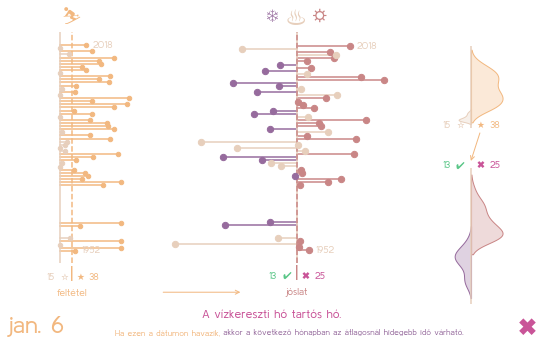

1


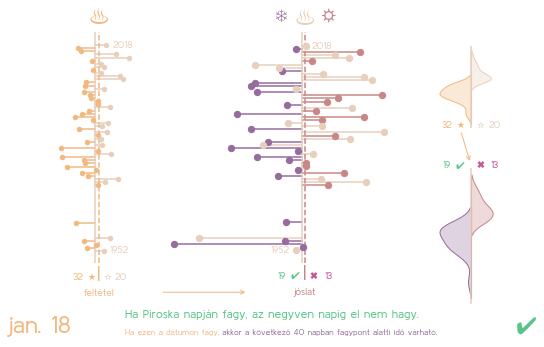

4


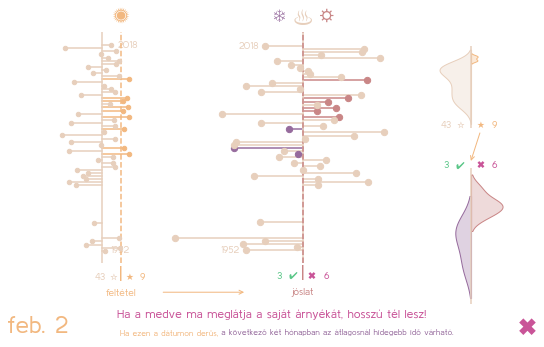

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """


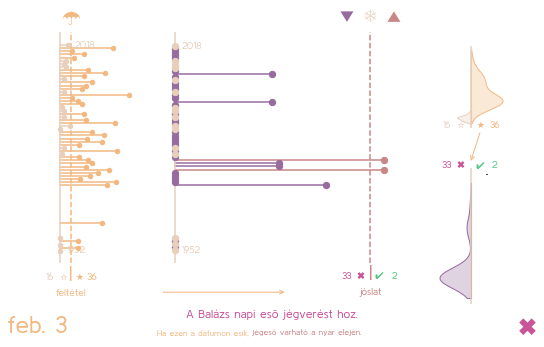

6


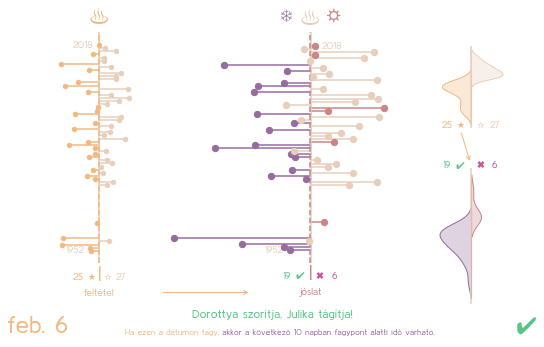

7


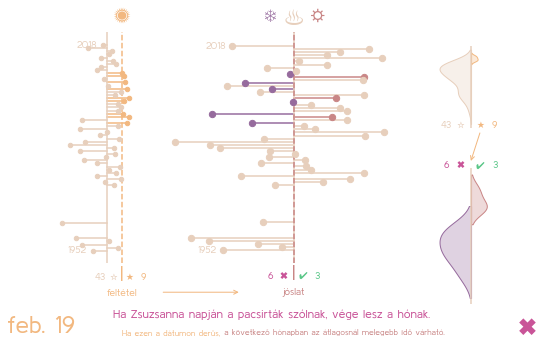

8


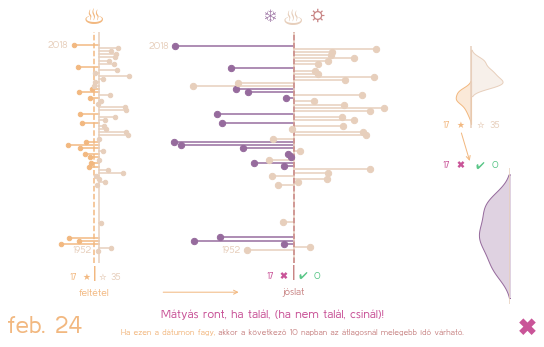

9


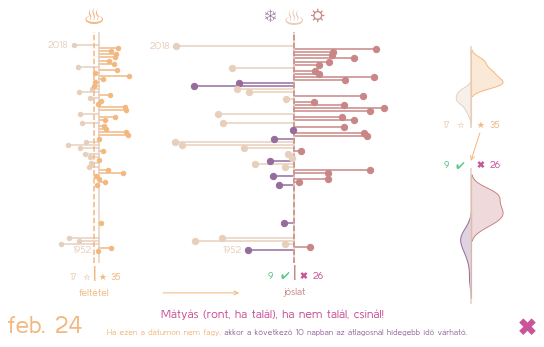

10


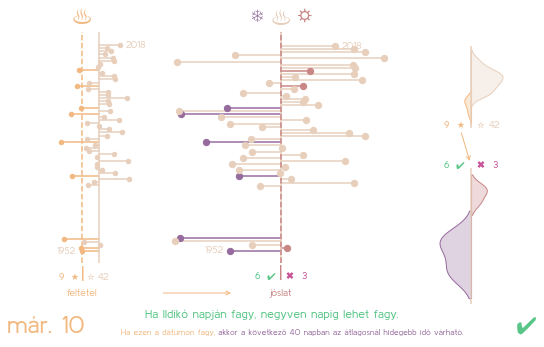

11


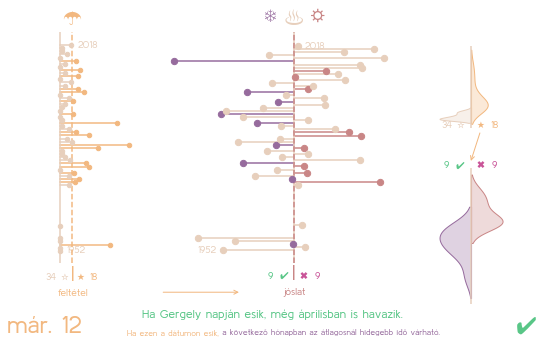

12


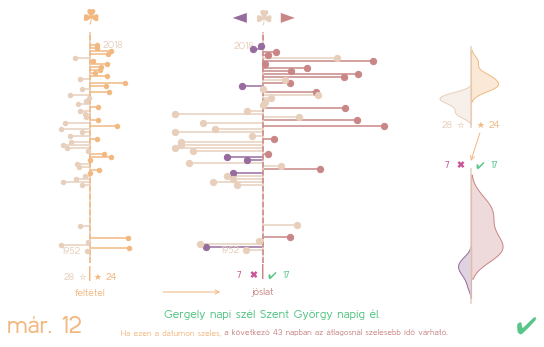

14


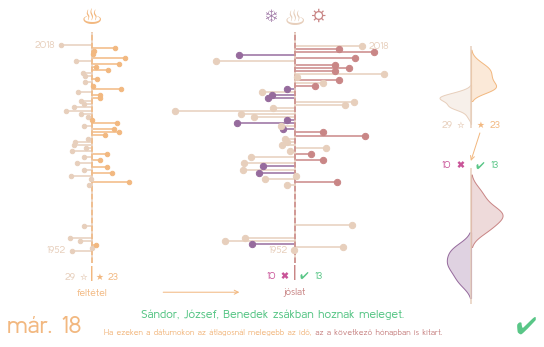

15


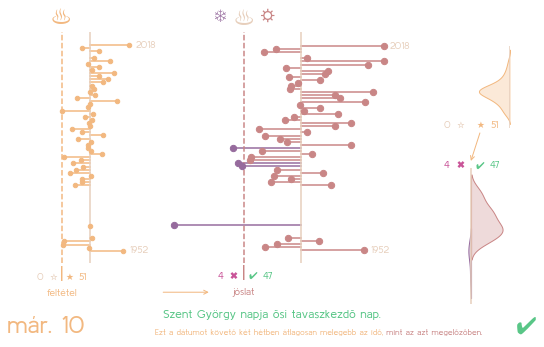

16


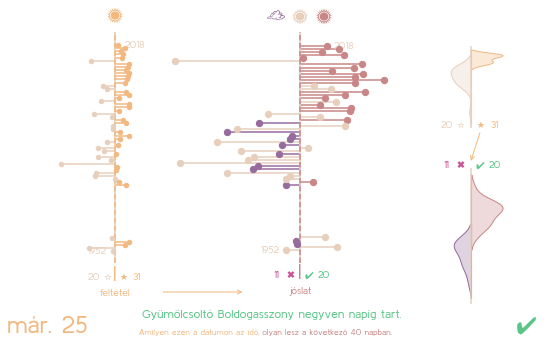

17


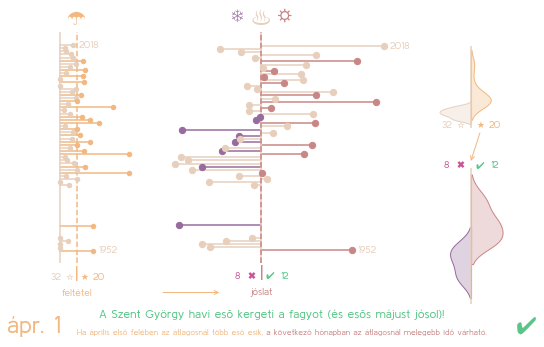

18


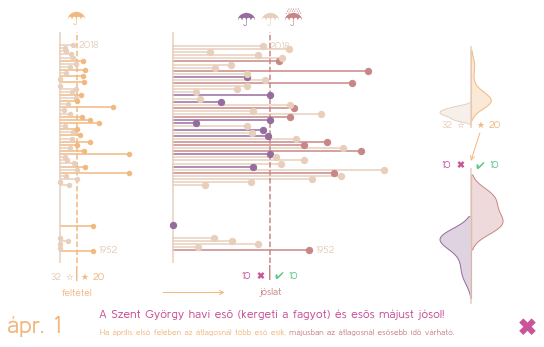

22


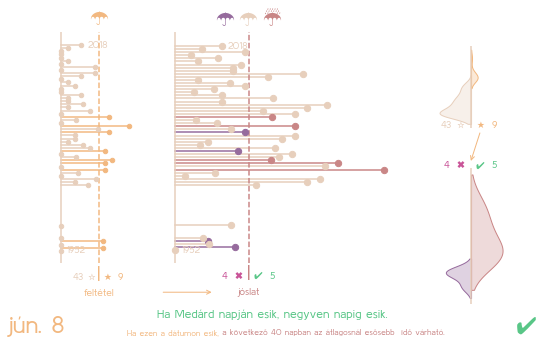

23


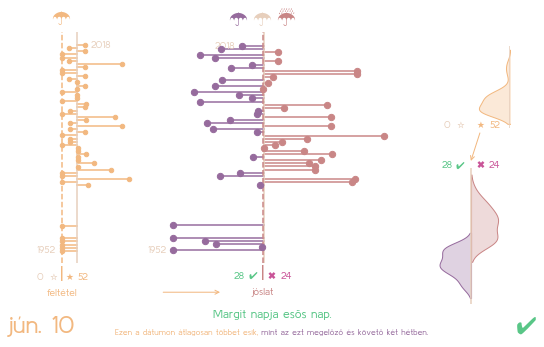

24


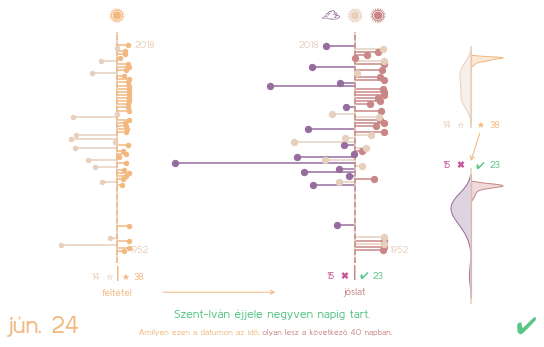

25


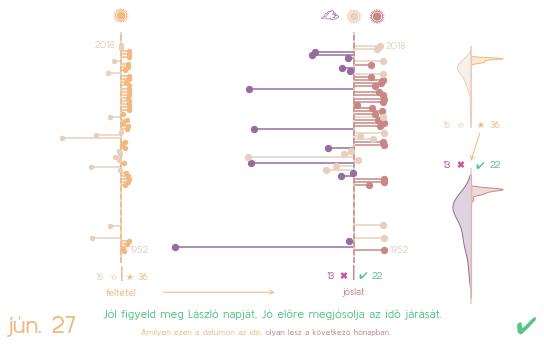

26


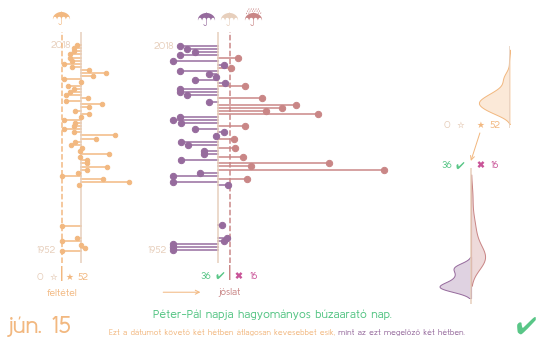

29


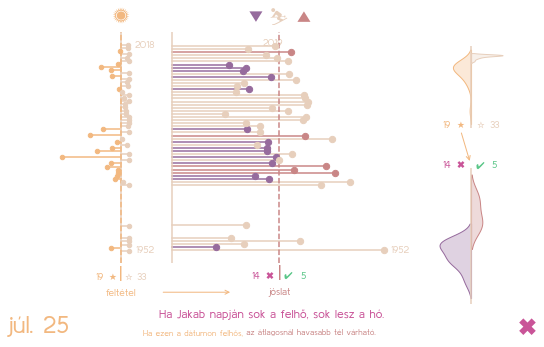

30


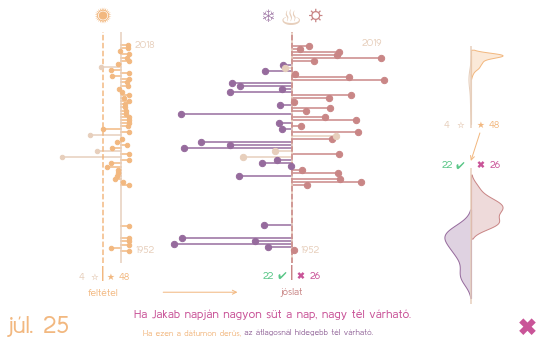

31


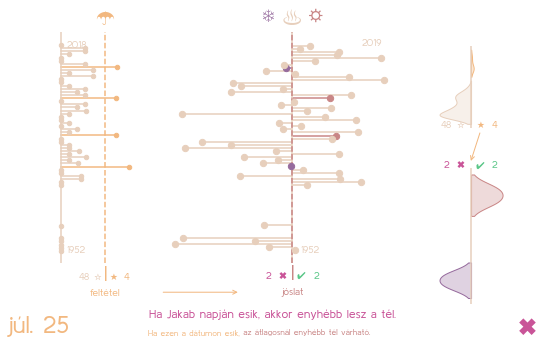

32


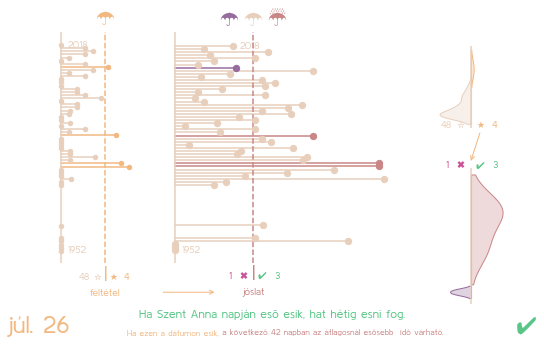

33


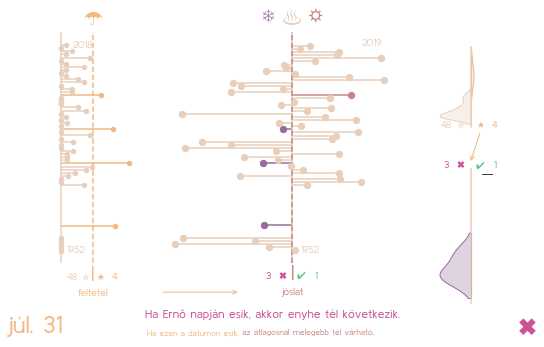

34


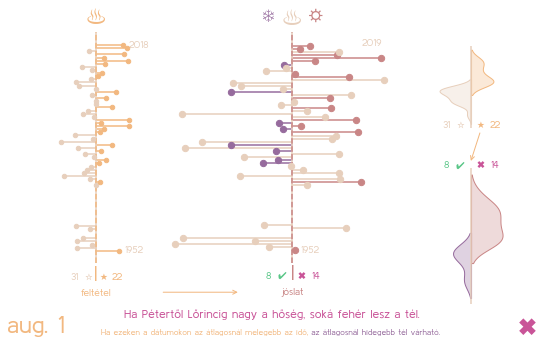

35


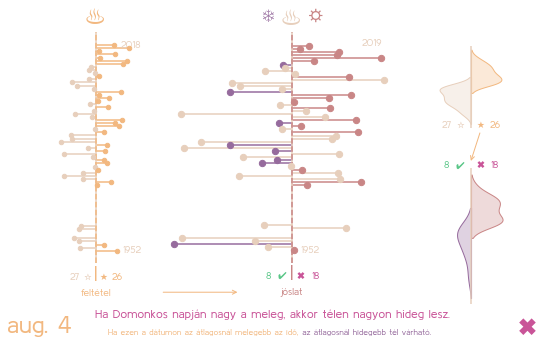

36


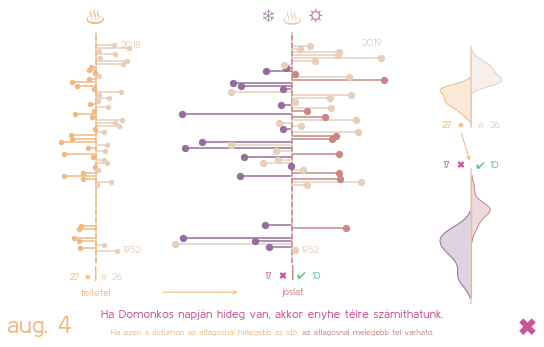

37


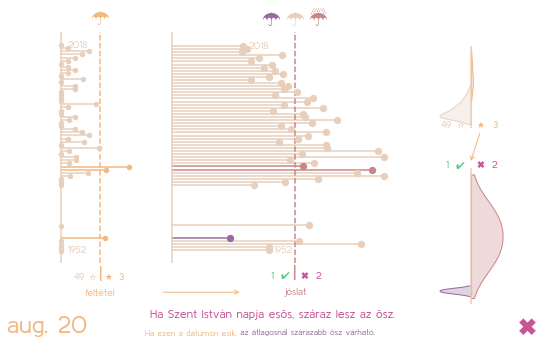

38


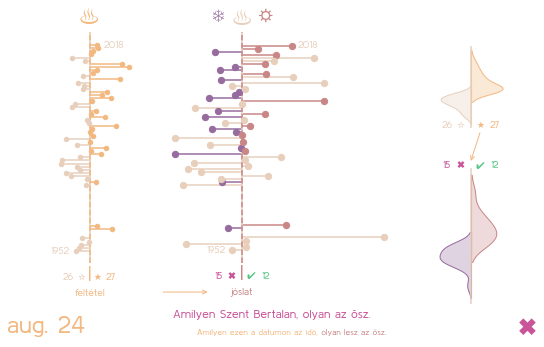

39


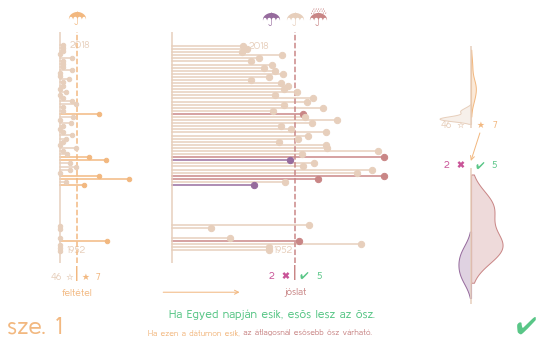

40


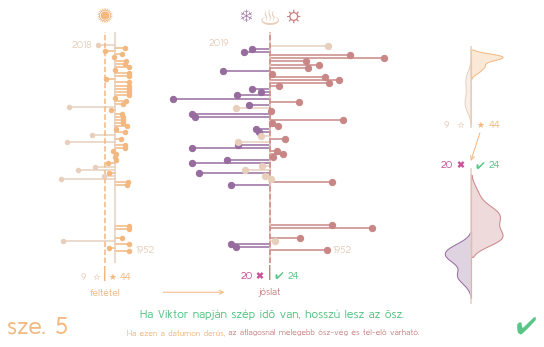

41


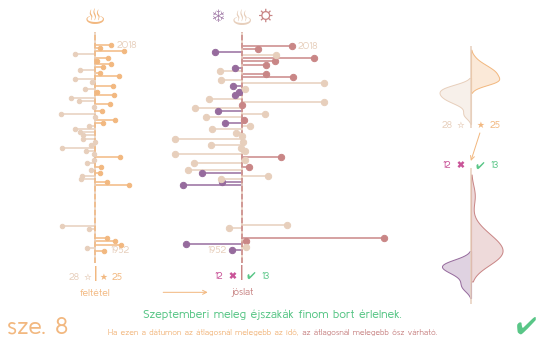

42


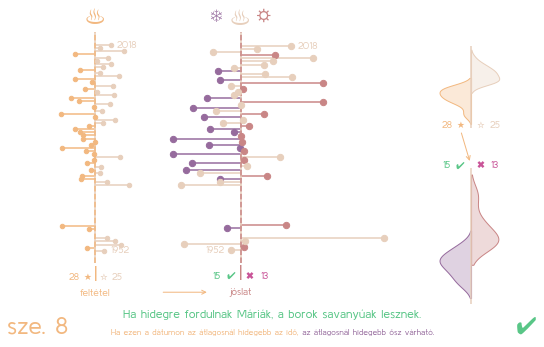

43


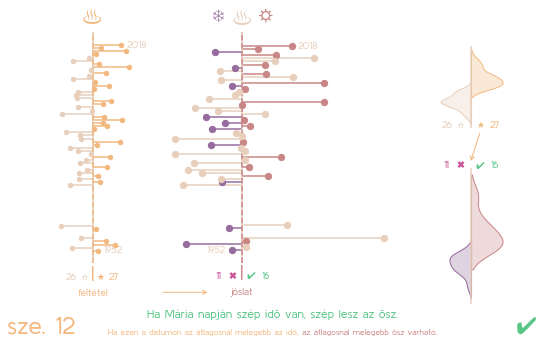

44


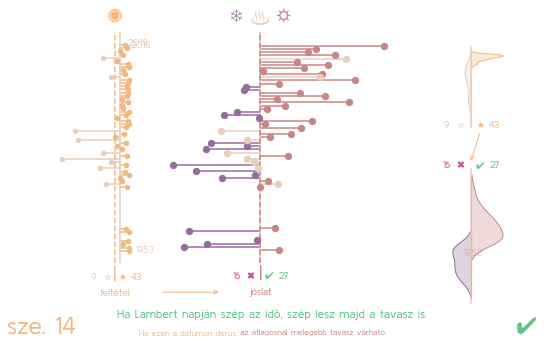

45


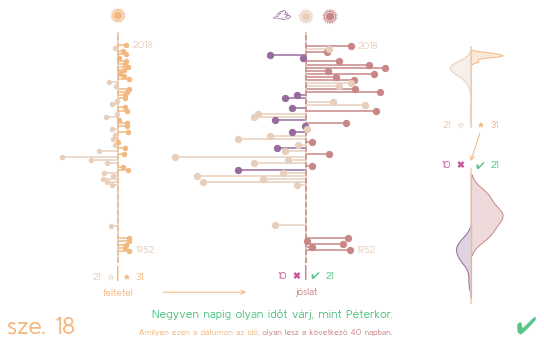

47


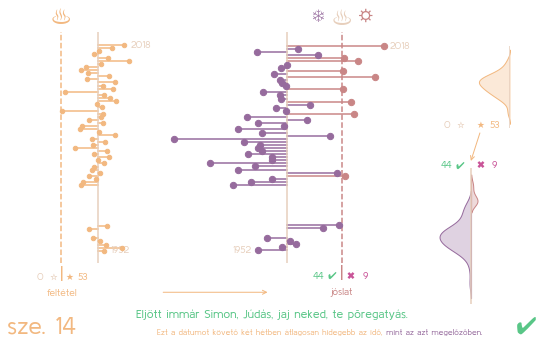

48


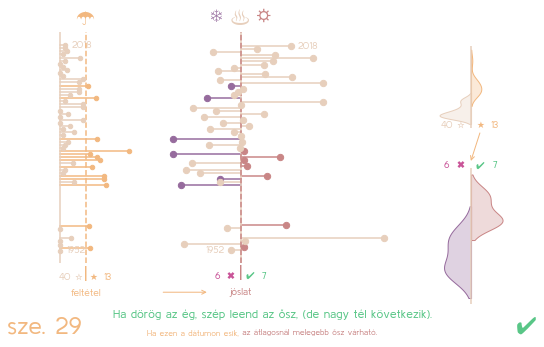

49


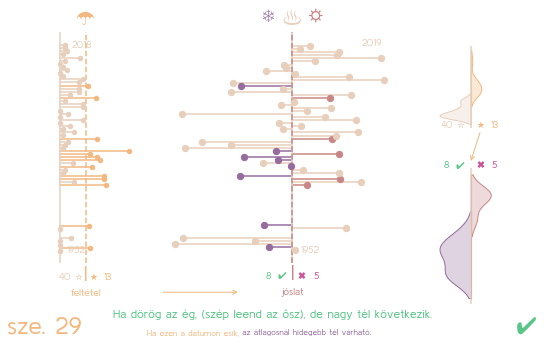

50


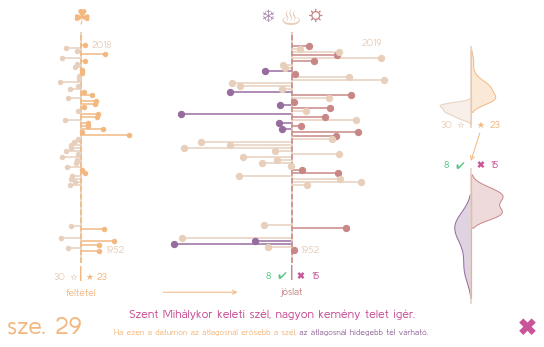

51


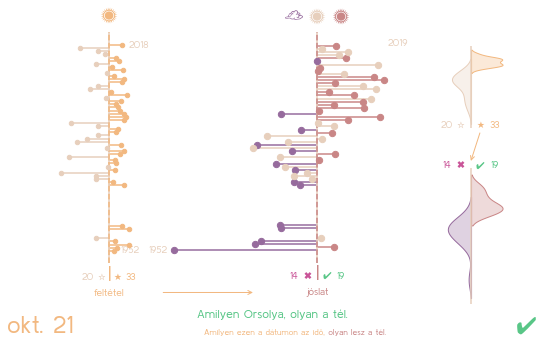

52


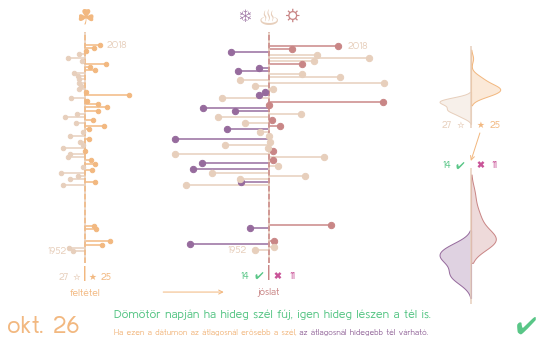

53


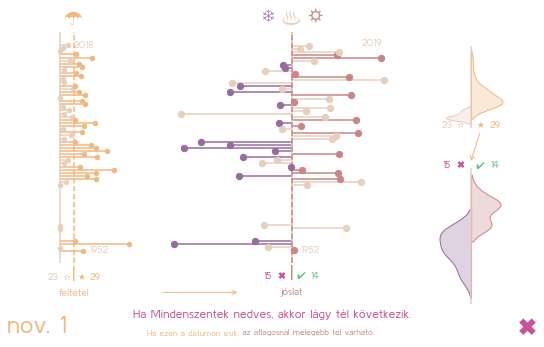

54


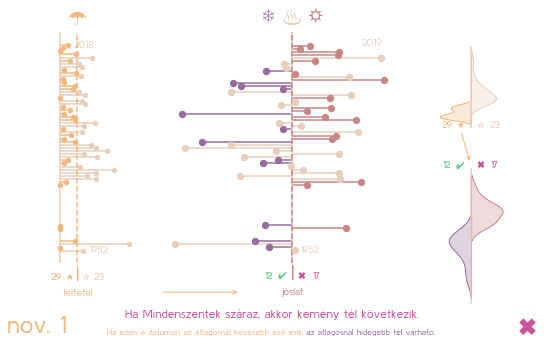

55


AttributeError: 'Line2D' object has no attribute 'set_edgecolor'

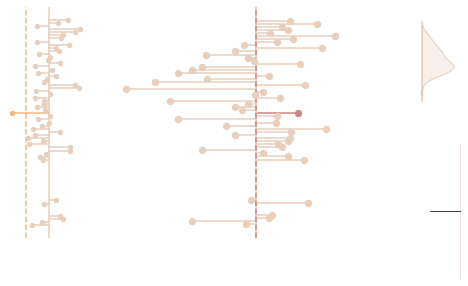

In [2841]:
mondasok=nepi['ID'].values
# mondasok=range(60,61)
# mondasok=[55]
for mondas in mondasok:
    nep=nepi.loc[mondas]
    if str(nep['Mennyiség'])!='nan':
        print(mondas)
        obs_key=mennyiseg_key[nep['Kondíció']]
        pred_key=mennyiseg_key[nep['Mennyiség']]
        observation_range=[nep['Dátum:mettől']+pd.to_timedelta('-1D'),nep['Dátum:meddig']+pd.to_timedelta('+2D')]
        prediction_range=[nep['Periódus:mettől'],nep['Periódus:meddig']+pd.to_timedelta('+1D')]
        observation_data,prediction_data=filter_data(dz,observation_range,prediction_range)

        #comparison
        if str(nep['Érték']) in ['A','B']:
            observation_ts,observation_th,prediction_ts,prediction_th,ertek_sign,irany_sign=\
                get_comp_data(observation_data,obs_key,nep['Érték'],\
                          prediction_data,pred_key,nep['Irány'])
        #time series
        else:
            ertek_sign=get_sign(nep['Érték'],obs_key)
            irany_sign=get_sign(nep['Irány'],pred_key)
            observation_ts,observation_th=get_ts_data(observation_data,obs_key,nep['Érték'])
            prediction_ts,prediction_th=get_ts_data(prediction_data,pred_key,nep['Irány'])
            
        color_obs_right,color_obs_left,obs_talalt_glyph,obs_nem_talalt_glyph,\
            color_pred_talalt,color_pred_nem_talalt,pred_talalt_glyph,pred_nem_talalt_glyph=\
            set_direction(ertek_sign, irany_sign)

        datum=str(nep['Dátum:mettől'].month)+'.'+str(nep['Dátum:mettől'].day)+'.'
        datum=str(nep['Dátums'])[:3]+'. '+str(nep['Dátum:mettől'].day)
        spine_plot(datum,nep['Mondás'].strip(),mondas,nep['Jelentés'].strip(),nep['Kondíció'],nep['Mennyiség'],
               observation_ts,observation_th,prediction_ts,prediction_th)